In [1]:
# !rm -r /content/sample_data
# !mkdir /content/images
# !mkdir /content/masks
# !wget https://box.vicos.si/borja/mastr1325_dataset/MaSTr1325_images_512x384.zip
# !wget https://box.vicos.si/borja/mastr1325_dataset/MaSTr1325_masks_512x384.zip
# !unzip MaSTr1325_images_512x384.zip -d /content/images
# !unzip MaSTr1325_masks_512x384.zip -d /content/masks
# !rm MaSTr1325_images_512x384.zip
# !rm MaSTr1325_masks_512x384.zip

In [2]:
import os
import math
import cv2 as cv
import numpy as np
import pandas as pd
import random as rn
import shutil as sh
import imagesize as ims
import tensorflow as tf
import albumentations as a
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
tf.__version__

'2.12.0'

In [3]:
img_dir = '/content/images'
mask_dir = '/content/masks'
df = pd.DataFrame({'image_path': sorted(os.listdir(img_dir)), 'mask_path': sorted(os.listdir(mask_dir))})
df.head()

,image_path,mask_path
0,0001.jpg,0001m.png
1,0002.jpg,0002m.png
2,0003.jpg,0003m.png
3,0004.jpg,0004m.png
4,0005.jpg,0005m.png


In [4]:
df['image_path'] = df['image_path'].apply(lambda a: os.path.join(img_dir, a))
df['mask_path'] = df['mask_path'].apply(lambda a: os.path.join(mask_dir, a))
df.head()

,image_path,mask_path
0,/content/images/0001.jpg,/content/masks/0001m.png
1,/content/images/0002.jpg,/content/masks/0002m.png
2,/content/images/0003.jpg,/content/masks/0003m.png
3,/content/images/0004.jpg,/content/masks/0004m.png
4,/content/images/0005.jpg,/content/masks/0005m.png


In [5]:
df['img_w'] = df['image_path'].apply(lambda x: ims.get(x)[0])
df['img_h'] = df['image_path'].apply(lambda x: ims.get(x)[1])
df['mask_w'] = df['mask_path'].apply(lambda x: ims.get(x)[0])
df['mask_h'] = df['mask_path'].apply(lambda x: ims.get(x)[1])
df.describe()

,img_w,img_h,mask_w,mask_h
count,1325.0,1325.0,1325.0,1325.0
mean,512.0,384.0,512.0,384.0
std,0.0,0.0,0.0,0.0
min,512.0,384.0,512.0,384.0
25%,512.0,384.0,512.0,384.0
50%,512.0,384.0,512.0,384.0
75%,512.0,384.0,512.0,384.0
max,512.0,384.0,512.0,384.0


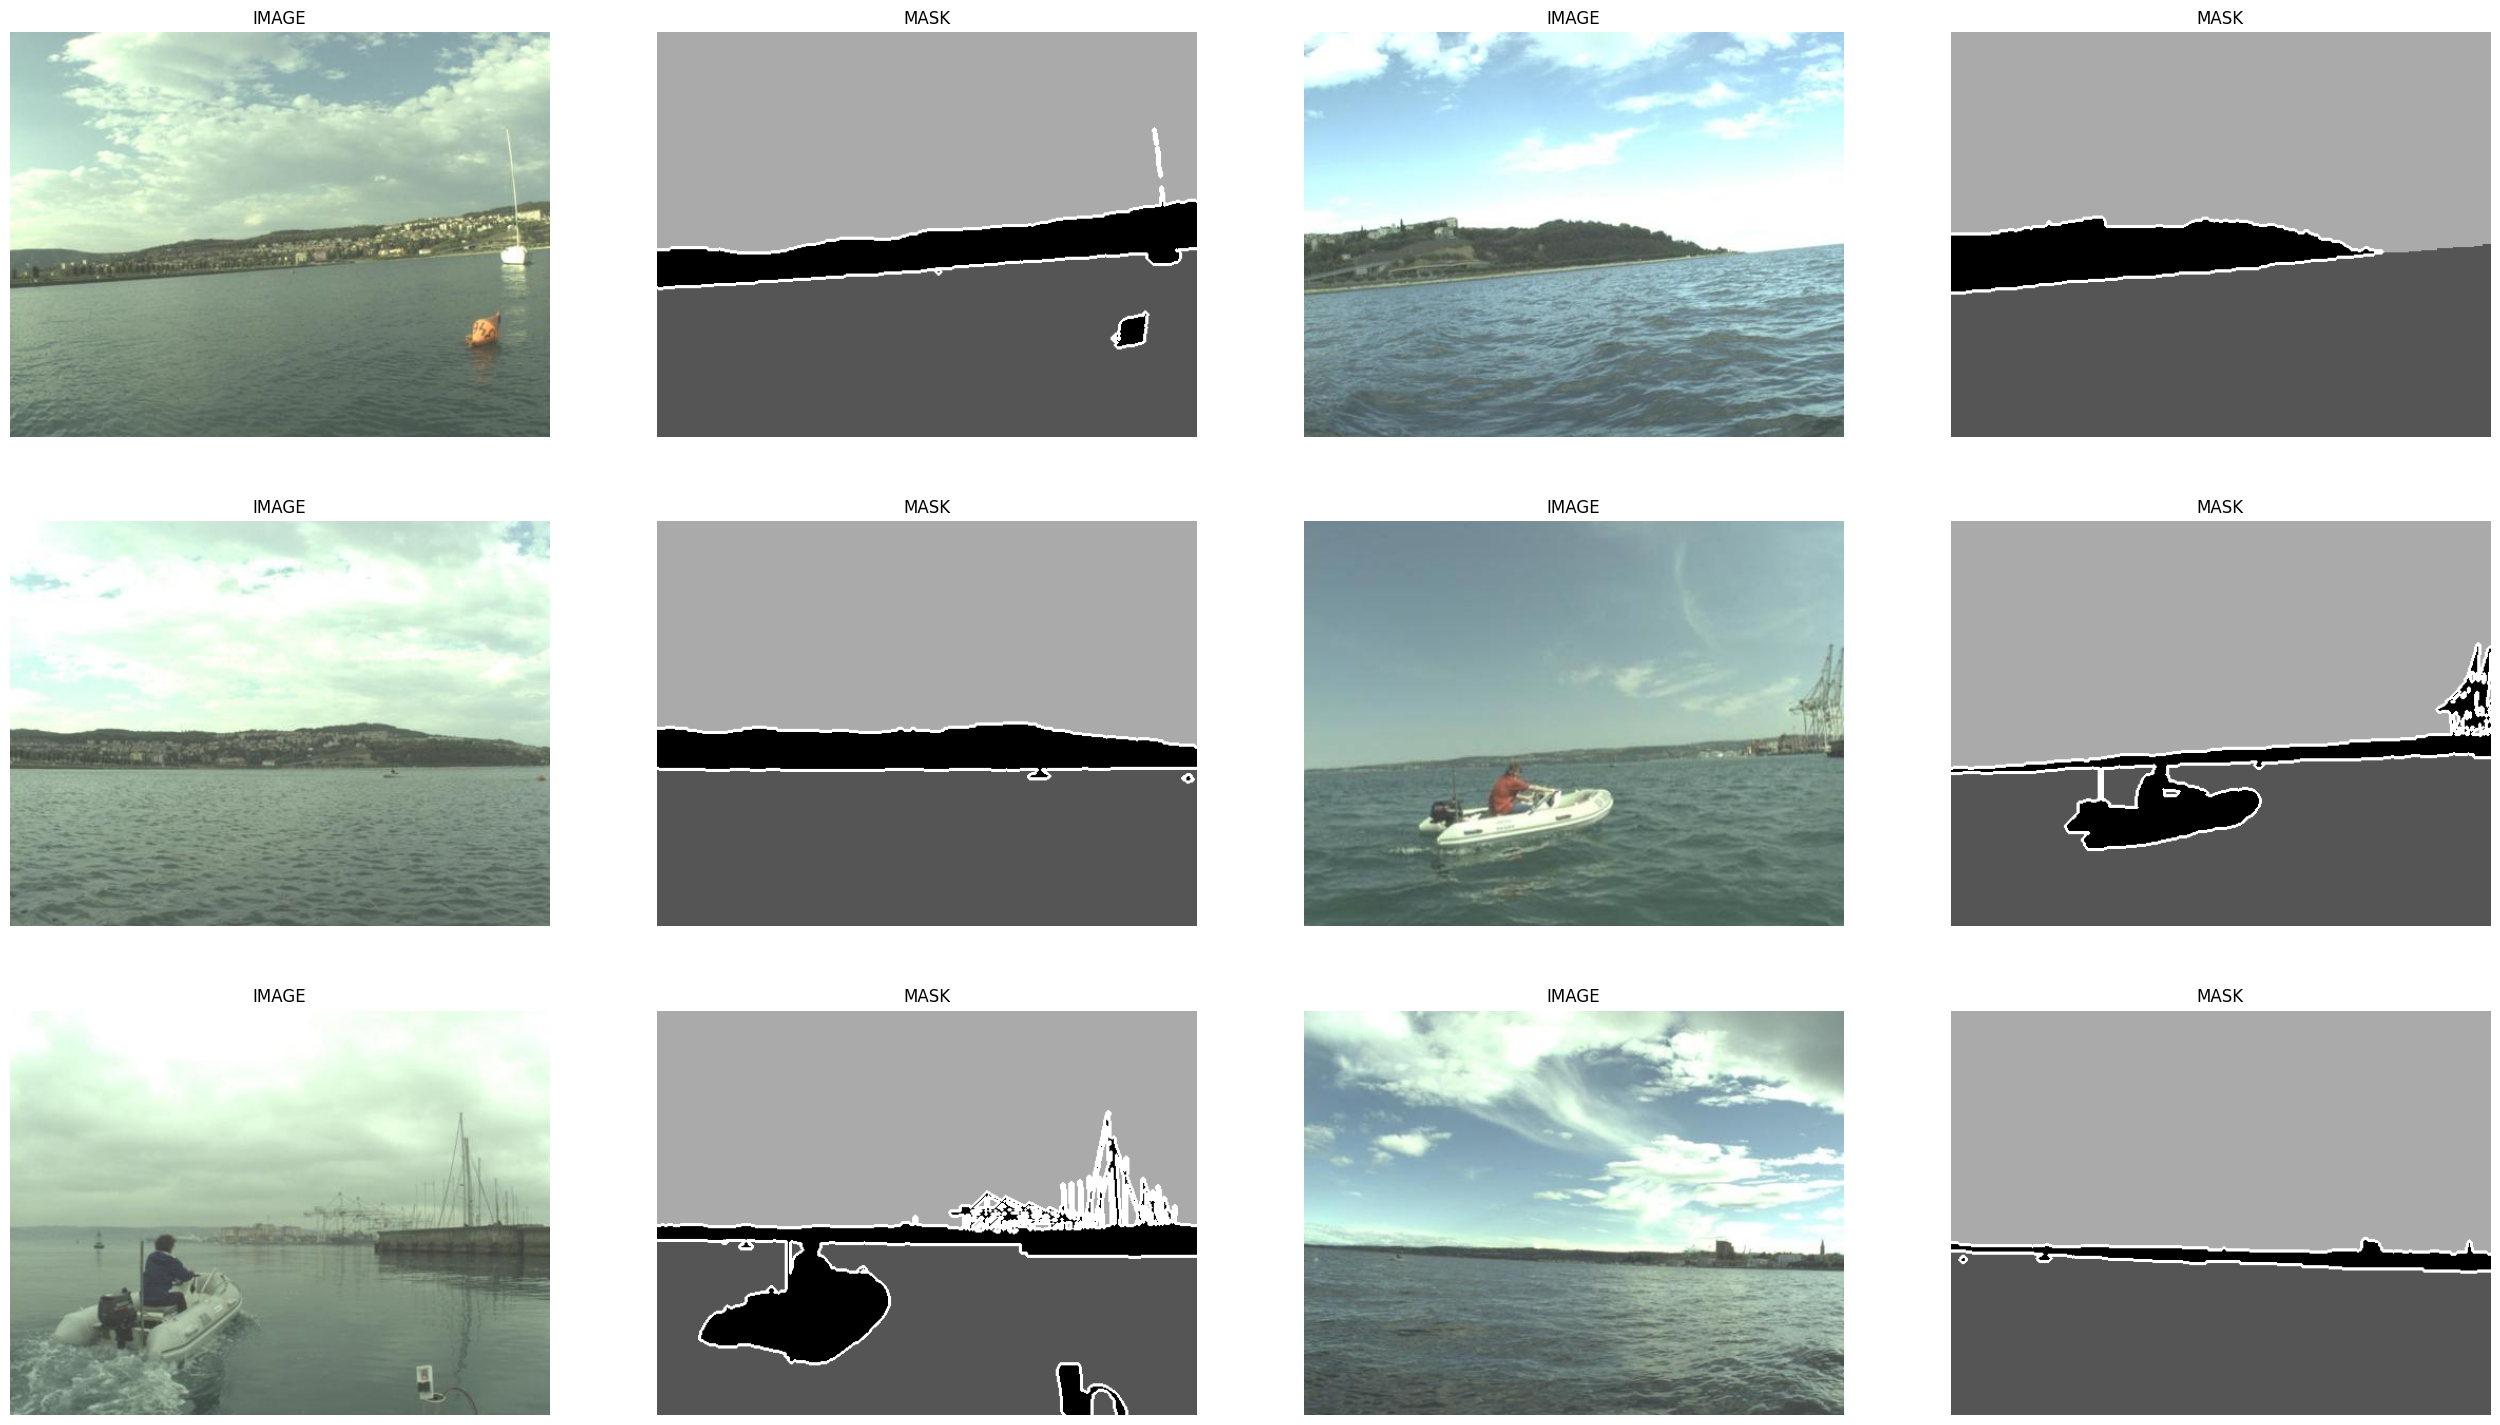

In [6]:
def display_images_and_masks(dataframe):
    rows = 3
    cols = 4
    fig, ax = plt.subplots(rows, cols, figsize=(32, 18))
    for i in range(rows):
        for j in range(2):
            index = rn.randint(0, dataframe.shape[0] - 1)
            img_path = dataframe['image_path'][index]
            mask_path = dataframe['mask_path'][index]
            img = cv.imread(img_path)
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            mask = cv.imread(mask_path)
            mask = np.array(mask, dtype='float32')
            mask = np.where(mask == 4.0, 3.0, mask)
            mask = mask * (255 / 3)
            mask = np.array(mask, dtype='uint8')
            ax[i, (j * 2) + 0].imshow(img)
            ax[i, (j * 2) + 1].imshow(mask)
            ax[i, (j * 2) + 0].set_title('IMAGE')
            ax[i, (j * 2) + 1].set_title('MASK')
            ax[i, (j * 2) + 0].axis('off')
            ax[i, (j * 2) + 1].axis('off')
    plt.show()
display_images_and_masks(df)

In [7]:
df.shape

(1325, 6)

In [8]:
train_df, val_df = train_test_split(df, test_size=325/1325, random_state=24)
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
train_df.shape, val_df.shape

((1000, 6), (325, 6))

In [9]:
class Pipeline(tf.keras.utils.Sequence):
    def __init__(self, dataframe, xcol, ycol, batch_size, img_h, img_w, img_c, num_classes, augment, transform):
        super(Pipeline, self).__init__()
        self.dataframe = dataframe
        self.xcol = xcol
        self.ycol = ycol
        self.batch_size = batch_size
        self.img_h = img_h
        self.img_w = img_w
        self.img_c = img_c
        self.num_classes = num_classes
        self.augment = augment
        self.transform = transform

    def __len__(self):
        return math.floor(self.dataframe.shape[0] / self.batch_size)

    def on_epoch_end(self):
        self.dataframe = self.dataframe.sample(frac=1)
        self.dataframe.reset_index(drop=True, inplace=True)

    def __getitem__(self, index):
        X = np.zeros(shape=(self.batch_size, self.img_h, self.img_w, self.img_c), dtype='float32')
        Y = np.zeros(shape=(self.batch_size, self.img_h, self.img_w, 1), dtype='float32')
        for i in range(self.batch_size):
            img_path = self.dataframe[self.xcol][i + (index * self.batch_size)]
            img = cv.imread(img_path)
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            mask_path = self.dataframe[self.ycol][i + (index * self.batch_size)]
            mask = cv.imread(mask_path)
            mask = cv.cvtColor(mask, cv.COLOR_BGR2RGB)
            mask = np.where(mask == 4, 3, mask)
            if self.augment:
                t = self.transform(image=img, mask=mask)
                img = t['image']
                mask = t['mask']
            img = np.array(img, dtype='float32')
            img = img / 255.0
            X[i, :, :, :] = img
            mask = np.array(mask, dtype='float32')
            mask = np.expand_dims(mask[:, :, 0], axis=-1)
            Y[i, :, :, :] = mask
        return X, Y
BATCH_SIZE = 4
IMG_H, IMG_W, IMG_C = 384, 512, 3
NUM_CLASSES = 4
AUGMENT = True
TRANSFORM = a.Compose([
    a.NoOp(p=0.8),
    a.HorizontalFlip(p=0.1),
    a.RandomCrop(width=IMG_W, height=IMG_H, p=0.1),
    a.SafeRotate(limit=(-0.1, 0.1), interpolation=cv.INTER_CUBIC, border_mode=cv.BORDER_REFLECT, p=0.1)
    ])
train_gen = Pipeline(train_df, 'image_path', 'mask_path', BATCH_SIZE, IMG_H, IMG_W, IMG_C, NUM_CLASSES, AUGMENT, TRANSFORM)
val_gen = Pipeline(val_df, 'image_path', 'mask_path', BATCH_SIZE, IMG_H, IMG_W, IMG_C, NUM_CLASSES, AUGMENT, TRANSFORM)
x, y = train_gen[0]
x.shape, y.shape

((4, 384, 512, 3), (4, 384, 512, 1))

In [10]:
X_inp = tf.keras.Input(shape=(IMG_H, IMG_W, IMG_C))
base = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_tensor=X_inp)
s1 = base.get_layer('block1_conv2').output # (384, 512, 64)
s2 = base.get_layer('block2_conv2').output # (192, 256, 128)
s3 = base.get_layer('block3_conv4').output # (96, 128, 256)
s4 = base.get_layer('block4_conv4').output # (48, 64, 512)
s5 = base.get_layer('block5_conv4').output # (24, 32, 512)
X = base.output
X = tf.keras.layers.Conv2D(1024, kernel_size=3, padding='same')(X)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Activation('relu')(X)
X = tf.keras.layers.Conv2D(512, kernel_size=3, padding='same')(X)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Activation('relu')(X)
X = tf.keras.layers.UpSampling2D(size=2, interpolation='bilinear')(X)
X = tf.keras.layers.Concatenate(axis=-1)([X, s5])
X = tf.keras.layers.Conv2D(512, kernel_size=3, padding='same')(X)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Activation('relu')(X)
X = tf.keras.layers.UpSampling2D(size=2, interpolation='bilinear')(X)
X = tf.keras.layers.Concatenate(axis=-1)([X, s4])
X = tf.keras.layers.Conv2D(256, kernel_size=3, padding='same')(X)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Activation('relu')(X)
X = tf.keras.layers.UpSampling2D(size=2, interpolation='bilinear')(X)
X = tf.keras.layers.Concatenate(axis=-1)([X, s3])
X = tf.keras.layers.Conv2D(128, kernel_size=3, padding='same')(X)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Activation('relu')(X)
X = tf.keras.layers.UpSampling2D(size=2, interpolation='bilinear')(X)
X = tf.keras.layers.Concatenate(axis=-1)([X, s2])
X = tf.keras.layers.Conv2D(64, kernel_size=3, padding='same')(X)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Activation('relu')(X)
X = tf.keras.layers.UpSampling2D(size=2, interpolation='bilinear')(X)
X = tf.keras.layers.Concatenate(axis=-1)([X, s1])
X = tf.keras.layers.Conv2D(NUM_CLASSES, kernel_size=1, padding='same', activation='softmax')(X)
model = tf.keras.Model(inputs=X_inp, outputs=X)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 384, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 384, 512, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [11]:
class CustomMetric(tf.keras.metrics.Metric):
    def __init__(self, num_classes):
        super(CustomMetric, self).__init__(name='custom_metric', dtype=tf.float32)
        self.num_classes = num_classes
        self.p = self.add_weight(name='precision', initializer='zeros')
        self.r = self.add_weight(name='recall', initializer='zeros')
        self.a = self.add_weight(name='accuracy', initializer='zeros')
        self.f = self.add_weight(name='f1', initializer='zeros')
        self.s = self.add_weight(name='sample', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.reshape(y_true, shape=[-1])
        y_pred = tf.argmax(y_pred, axis=-1)
        y_pred = tf.reshape(y_pred, shape=[-1])

        cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=self.num_classes)
        cm = tf.cast(cm, dtype=tf.float32)

        tp = tf.linalg.diag_part(cm)
        tp_fp = tf.reduce_sum(cm, axis=-1)
        tp_fn = tf.reduce_sum(cm, axis=0)

        prec = tp / tp_fp
        rec = tp / tp_fn
        acc = tf.reduce_sum(tp) / tf.reduce_sum(cm)
        f1 = (2 * prec * rec) / (prec + rec)

        prec = tf.where(tf.math.is_nan(prec), 0.0, prec)
        rec = tf.where(tf.math.is_nan(rec), 0.0, rec)
        acc = tf.where(tf.math.is_nan(acc), 0.0, acc)
        f1 = tf.where(tf.math.is_nan(f1), 0.0, f1)

        mean_prec = tf.reduce_mean(prec)
        mean_rec = tf.reduce_mean(rec)
        mean_f1 = tf.reduce_mean(f1)

        self.p.assign_add(mean_prec)
        self.r.assign_add(mean_rec)
        self.a.assign_add(acc)
        self.f.assign_add(mean_f1)
        self.s.assign_add(1.0)

    def result(self):
        return {'mean_precision': self.p / self.s, 'mean_recall': self.r / self.s, 'accuracy': self.a / self.s, 'mean_f1': self.f / self.s}

    def reset_state(self):
        self.p.assign(0.)
        self.r.assign(0.)
        self.a.assign(0.)
        self.f.assign(0.)
        self.s.assign(0.)
metric = CustomMetric(NUM_CLASSES)

In [12]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataframe, x, y, img_h, img_w):
        super(CustomCallback, self).__init__()
        self.dataframe = dataframe
        self.x = x
        self.y = y
        self.img_h = img_h
        self.img_w = img_w

    def on_epoch_end(self, epoch, logs=None):
        fig, ax = plt.subplots(1, 3, figsize=(28, 12))
        index = rn.randint(0, self.dataframe.shape[0] - 1)
        mask = self.dataframe[self.y][index]
        mask = cv.imread(mask)
        mask = cv.resize(mask, (self.img_w, self.img_h))
        mask = np.where(mask == 4, 3, mask)
        mask = np.array(mask, dtype='float32') * (255 / 3)
        mask = np.array(mask, dtype='uint8')
        ax[0].imshow(mask)
        ax[0].set_title('TRUE MASK')
        ax[0].axis('off')
        img = self.dataframe[self.x][index]
        img = cv.imread(img)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.resize(img, (self.img_w, self.img_h))
        ax[1].imshow(img)
        ax[1].set_title('INPUT IMAGE')
        ax[1].axis('off')
        pred = np.array(img, dtype='float32')
        pred = pred / 255.0
        pred = np.expand_dims(pred, axis=0)
        pred = self.model.predict(pred)
        pred = np.squeeze(pred, axis=0)
        pred = np.argmax(pred, axis=-1)
        pred = np.expand_dims(pred, axis=-1)
        pred = np.concatenate([pred, pred, pred], axis=-1)
        pred = pred * (255 / 3)
        pred = np.array(pred, dtype='uint8')
        ax[2].imshow(pred)
        ax[2].set_title('PRED MASK')
        ax[2].axis('off')
        plt.show()
cc = CustomCallback(val_df, 'image_path', 'mask_path', IMG_H, IMG_W)

Epoch 1/100
1/1 [==============================] - 3s 3s/step


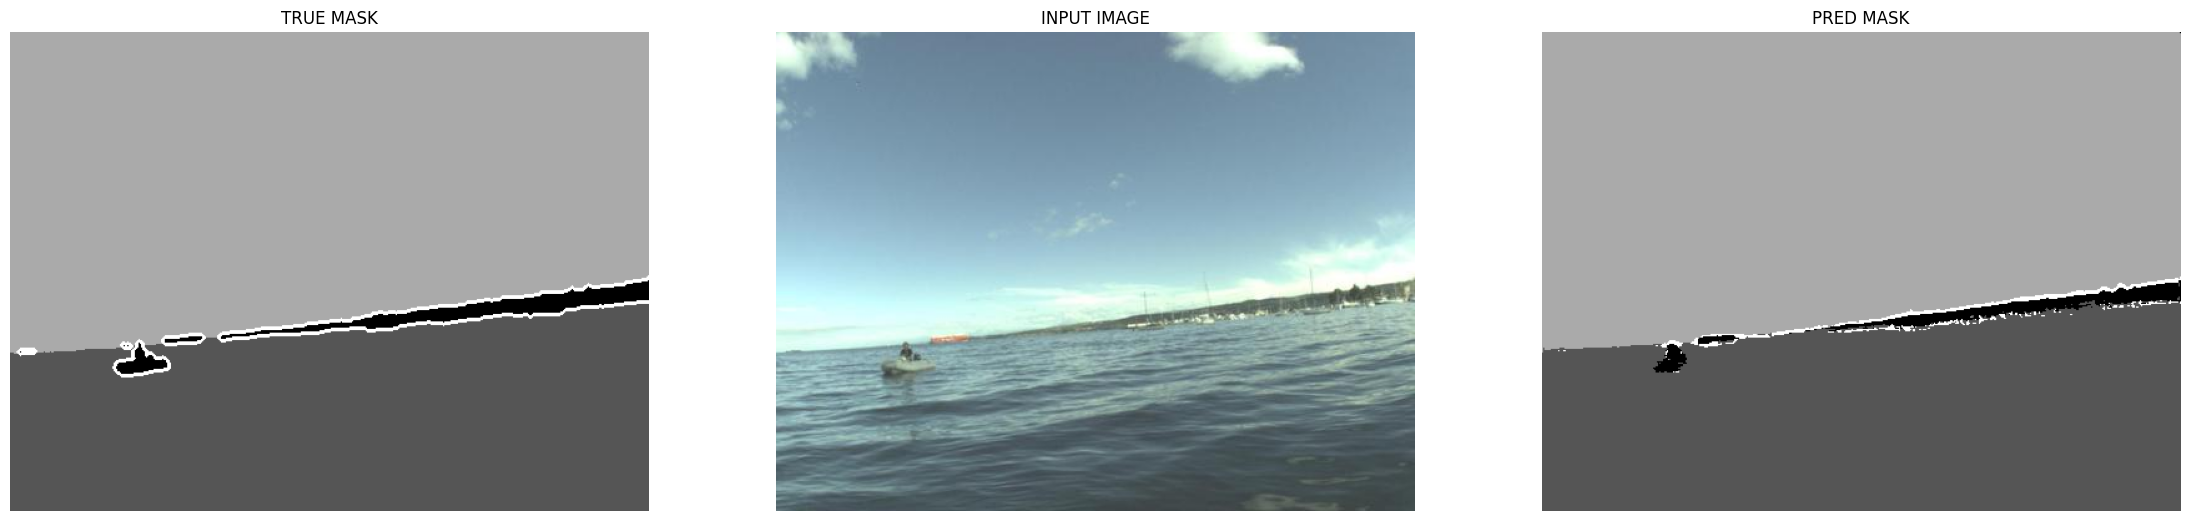

250/250 [==============================] - 191s 626ms/step - loss: 0.2556 - mean_io_u: 0.6775 - mean_precision: 0.6977 - mean_recall: 0.7601 - accuracy: 0.7733 - mean_f1: 0.6651 - val_loss: 0.1058 - val_mean_io_u: 0.7684 - val_mean_precision: 0.8097 - val_mean_recall: 0.8882 - val_accuracy: 0.9707 - val_mean_f1: 0.8381 - lr: 1.0000e-04
Epoch 2/100
1/1 [==============================] - 0s 35ms/step


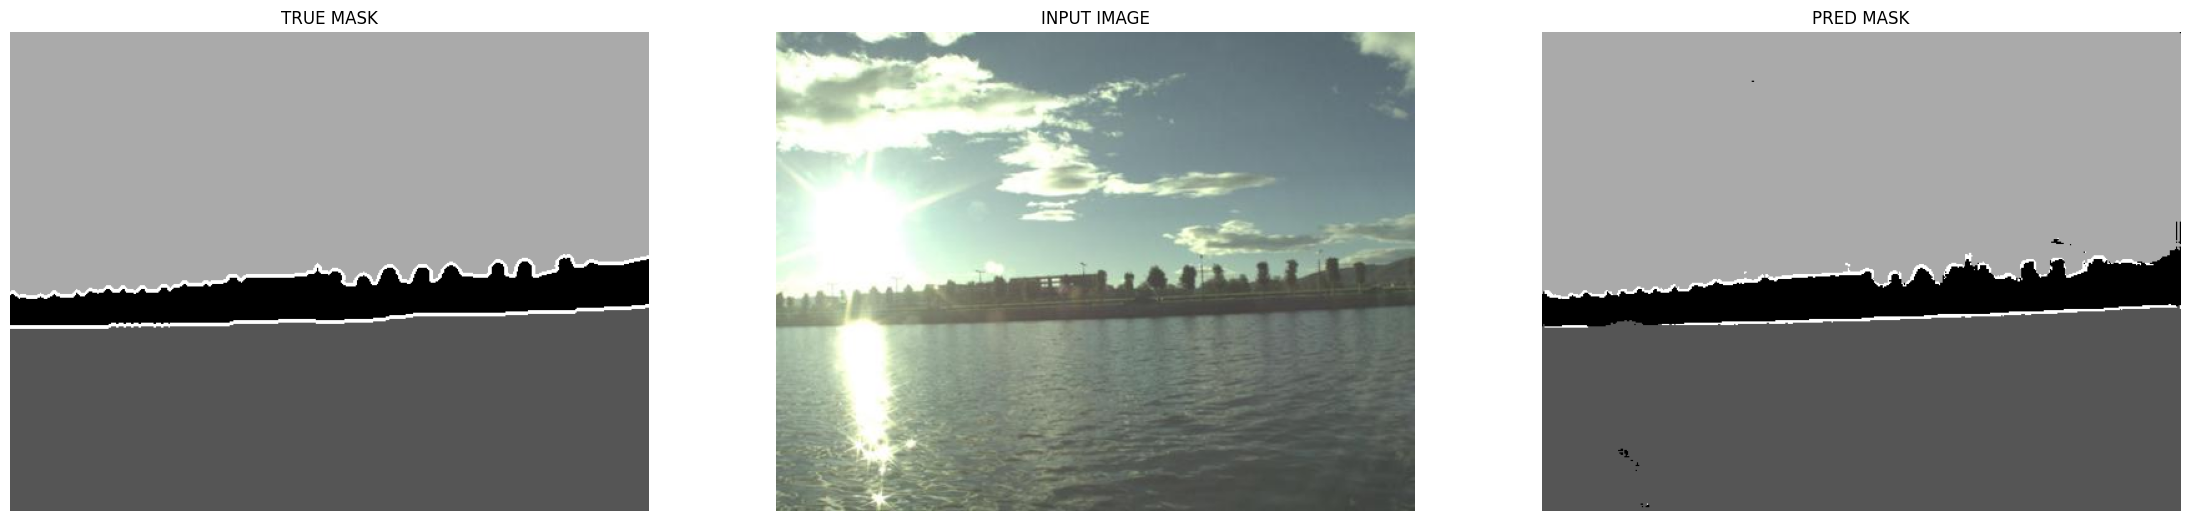

250/250 [==============================] - 152s 606ms/step - loss: 0.0742 - mean_io_u: 0.8079 - mean_precision: 0.8556 - mean_recall: 0.8836 - accuracy: 0.9765 - mean_f1: 0.8660 - val_loss: 0.0663 - val_mean_io_u: 0.8019 - val_mean_precision: 0.8440 - val_mean_recall: 0.9011 - val_accuracy: 0.9786 - val_mean_f1: 0.8631 - lr: 1.0000e-04
Epoch 3/100
1/1 [==============================] - 0s 28ms/step


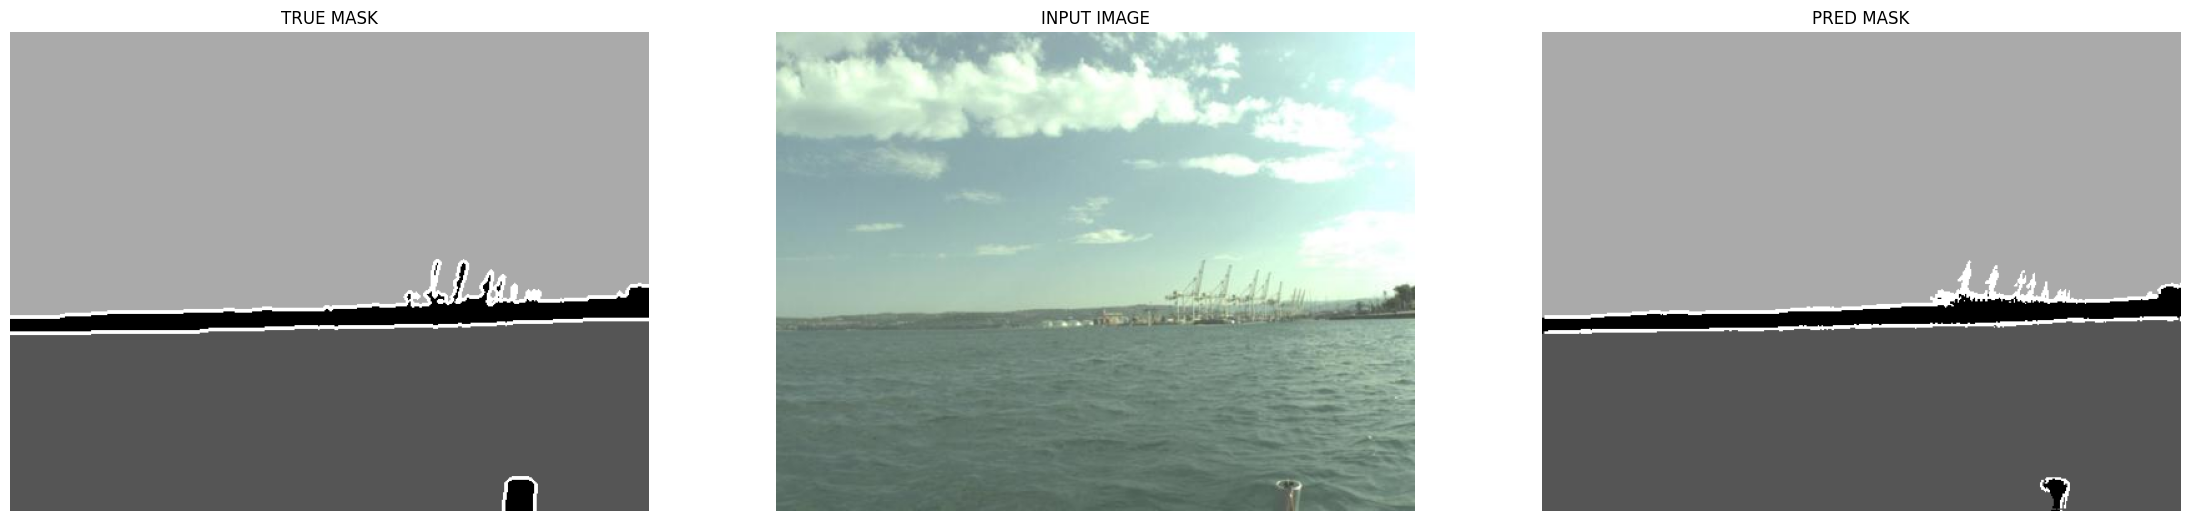

250/250 [==============================] - 147s 586ms/step - loss: 0.0666 - mean_io_u: 0.8147 - mean_precision: 0.8697 - mean_recall: 0.8888 - accuracy: 0.9788 - mean_f1: 0.8767 - val_loss: 0.0705 - val_mean_io_u: 0.8109 - val_mean_precision: 0.8619 - val_mean_recall: 0.8950 - val_accuracy: 0.9764 - val_mean_f1: 0.8766 - lr: 1.0000e-04
Epoch 4/100
1/1 [==============================] - 0s 22ms/step


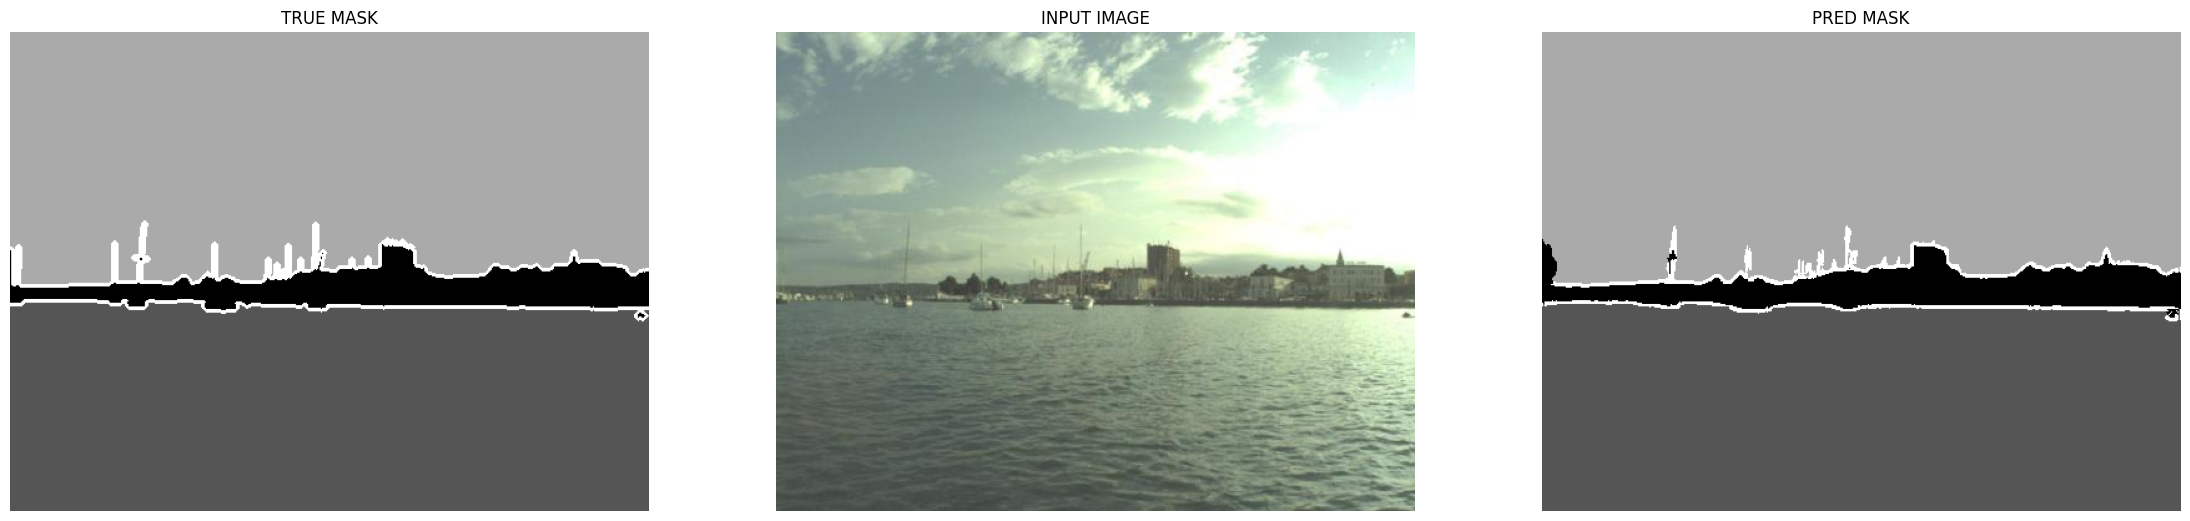

250/250 [==============================] - 152s 607ms/step - loss: 0.0563 - mean_io_u: 0.8279 - mean_precision: 0.8814 - mean_recall: 0.8948 - accuracy: 0.9814 - mean_f1: 0.8863 - val_loss: 0.0620 - val_mean_io_u: 0.8343 - val_mean_precision: 0.8884 - val_mean_recall: 0.8988 - val_accuracy: 0.9817 - val_mean_f1: 0.8930 - lr: 1.0000e-04
Epoch 5/100
1/1 [==============================] - 0s 22ms/step


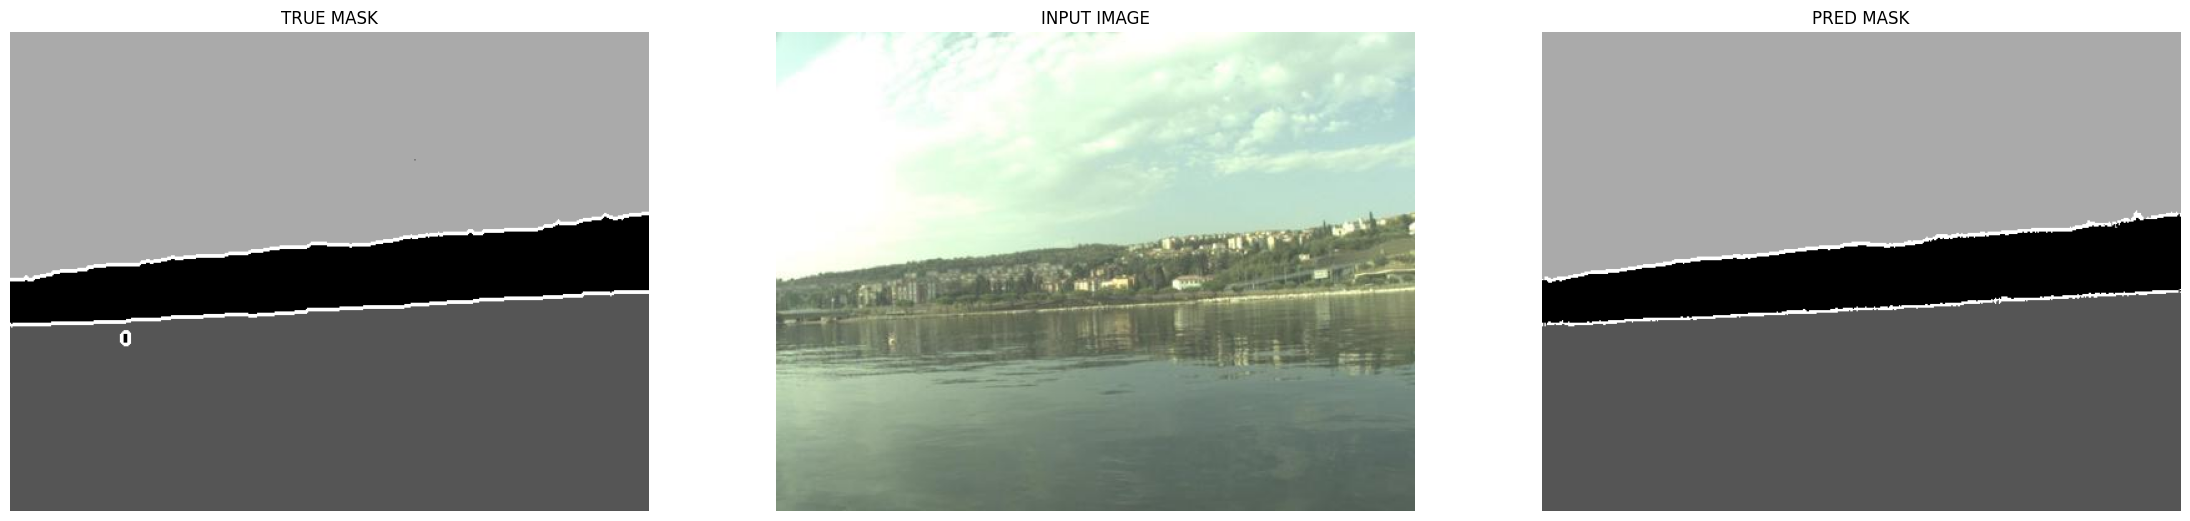

250/250 [==============================] - 153s 611ms/step - loss: 0.0529 - mean_io_u: 0.8306 - mean_precision: 0.8901 - mean_recall: 0.9018 - accuracy: 0.9830 - mean_f1: 0.8947 - val_loss: 0.0530 - val_mean_io_u: 0.8238 - val_mean_precision: 0.8687 - val_mean_recall: 0.9037 - val_accuracy: 0.9808 - val_mean_f1: 0.8841 - lr: 1.0000e-04
Epoch 6/100
 97/250 [==========>...................] - ETA: 1:19 - loss: 0.0515 - mean_io_u: 0.8311 - mean_precision: 0.8839 - mean_recall: 0.8968 - accuracy: 0.9809 - mean_f1: 0.8888

In [ ]:
EPOCHS = 100
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=6, restore_best_weights=True)
mc = tf.keras.callbacks.ModelCheckpoint(filepath='weights.h5', monitor='val_loss', mode='min', save_best_only=True)
rlrop = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=3, factor=0.4)
mean_iou = tf.keras.metrics.MeanIoU(num_classes=NUM_CLASSES, dtype=tf.float32, sparse_y_true=True, sparse_y_pred=False)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=[mean_iou, metric])
fit = model.fit(train_gen, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[es, mc, rlrop, cc], validation_data=val_gen, validation_batch_size=BATCH_SIZE)

In [ ]:
model.save('SeaUNet.keras')